### Import Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thobelasixpence","key":"f3a3b4df5c89076876032b54ad5650c6"}'}

In [6]:
# create a kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
# permission for json files to act
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:13<00:00, 180MB/s]
100% 2.29G/2.29G [00:13<00:00, 184MB/s]


In [9]:
!pip install zip_files

In [10]:
from zipfile import ZipFile

file_name="chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
      zip.extractall()
      print('Done')

Done


### Dataset Directory

In [11]:
data_directory = '/content/chest_xray'

In [12]:
dataset = r'/content/chest_xray/train'

In [13]:
# find the training path directory for images
train_dir = os.path.join(data_directory, "train") # get the path of training images in train folder

# find the test path directory for images
test_dir = os.path.join(data_directory, "test")# get the path of test images in test folder

# find the validdation path directory for images
val_dir = os.path.join(data_directory, "val")# get the path of validation images in val folder

### Classes of Images

In [14]:
''' PNEUMONIA images '''
pneumonia_train_imgs = glob.glob(train_dir + "/PNEUMONIA/*.jpeg")
''' NORMAL  images '''
normal_train_imgs = glob.glob(train_dir + "/NORMAL/*.jpeg")

In [15]:
pneumonia_imgs = os.listdir(train_dir+"/PNEUMONIA") # get covid images from the directory
normal_imgs = os.listdir(dataset+"/NORMAL") # get normal images from the directory

### Compare the Pneumonia and Normal X-Ray Images

In [16]:
import skimage
from skimage.transform import rescale, resize, downscale_local_mean

In [17]:
import cv2

In [ ]:

def image_plotter(num):
    '''this function gets the pneumonia and normal image and concentanate them to observe the difference'''
    normal = cv2.imread(dataset+'NORMAL//'+normal_imgs[num]) # get the normal image from the normal images
    normal = resize(normal, output_shape=(150, 150, 3)) # resize the image
    pneumonia = cv2.imread(dataset+'PNEUMONIA//'+pneumonia_imgs[num]) # get the pneumonia image from the normal images
    pneumonia = resize(pneumonia, (150, 150, 3), mode = 'reflect') # resize the image
    pair = np.concatenate((normal, pneumonia), axis = 1)
    print("Normal Chest vs Pneumonia Chest X-Ray")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

for i in range(0,5):
    image_plotter(i)

In [19]:
# convert the two classes into a dataframe
df = pd.DataFrame(np.concatenate([[0] * len(normal_train_imgs), [1] * len(pneumonia_train_imgs)]), columns = ["class"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


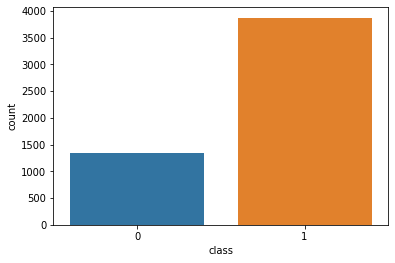

In [20]:
import seaborn as sns
# display the classes in a countplot
sns.countplot(df['class'],data=df)

### Data Augmentation

In [21]:
train_datagen = ImageDataGenerator(rescale = 1/225,
                                  shear_range = 10,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   fill_mode = 'nearest'
                                  )

In [22]:
val_datagen = ImageDataGenerator(rescale = 1/225)

### Model Building

In [23]:
''' VGG16 Model '''
base_model = VGG16(include_top = False, weights = 'imagenet')# base model
'''Freezing layers'''
for layer in base_model.layers:
    layer.trainable = False

head_model = base_model.output # head model, whatever the output is from the base model, it is gonna connect with the new head model

'''GlobalAveragePooling Layer'''
head_model = keras.layers.GlobalAveragePooling2D()(head_model)
head_model = keras.layers.Dense(64, activation = 'relu')(head_model)

'''Classification layer'''
head_model = Dense(1, activation='sigmoid')(head_model) 

'''final model'''
model = keras.Model(base_model.input, outputs= head_model)

Learning_Rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(Learning_Rate, decay_steps = 100000, decay_rate = 0.96, staircase = True)

'''Compile the model'''
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr_schedule), metrics = ['accuracy'])
print("compiling Stats")

58900480/58889256 [==============================] - 1s 0us/step
compiling Stats


In [24]:
# a look on how is the model 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
'''getting all the required flows from directory for training'''
train_ds = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size=16, class_mode = 'binary')
val_ds = val_datagen.flow_from_directory(val_dir, target_size = (150, 150), batch_size = 8, class_mode = 'binary')
test_ds = val_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 32, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
'''training'''
history = model.fit(train_ds, steps_per_epoch = 100, validation_data = val_ds, epochs = 20)

Epoch 1/20
100/100 [==============================] - 41s 297ms/step - loss: 1.9250 - accuracy: 0.7650 - val_loss: 0.4375 - val_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 28s 279ms/step - loss: 0.4491 - accuracy: 0.8419 - val_loss: 0.1930 - val_accuracy: 0.8750
Epoch 3/20
100/100 [==============================] - 30s 300ms/step - loss: 0.3075 - accuracy: 0.8819 - val_loss: 0.5615 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 28s 280ms/step - loss: 0.3545 - accuracy: 0.8775 - val_loss: 0.2265 - val_accuracy: 0.9375
Epoch 5/20
100/100 [==============================] - 29s 294ms/step - loss: 0.2826 - accuracy: 0.8900 - val_loss: 0.5322 - val_accuracy: 0.8125
Epoch 6/20
100/100 [==============================] - 36s 361ms/step - loss: 0.2762 - accuracy: 0.9019 - val_loss: 0.5798 - val_accuracy: 0.8125
Epoch 7/20
100/100 [==============================] - 28s 284ms/step - loss: 0.2750 - accuracy: 0.9069 - val_loss: 0.3632 - val_ac

In [27]:
'''evaluating model'''
accuracy = model.evaluate_generator(test_ds, 624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [28]:
accuracy

0.8108974099159241

In [ ]:
'''unfreezing layers'''
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
'''fine tuning the model for better perfomance'''
learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(Learning_Rate, decay_steps = 100000, decay_rate = 0.96, staircase = True)
'''Compile the model'''
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr_schedule), loss = keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = [keras.metrics.BinaryAccuracy()])
print("compiling Stats")

compiling Stats


In [ ]:
'''training'''
history = model.fit(train_ds, steps_per_epoch = 50, validation_data = val_ds, epochs = 100)

In [ ]:
'''evaluating model'''
accuracy = model.evaluate_generator(test_ds, 624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [ ]:
accuracy

0.625

### Model Evaluation

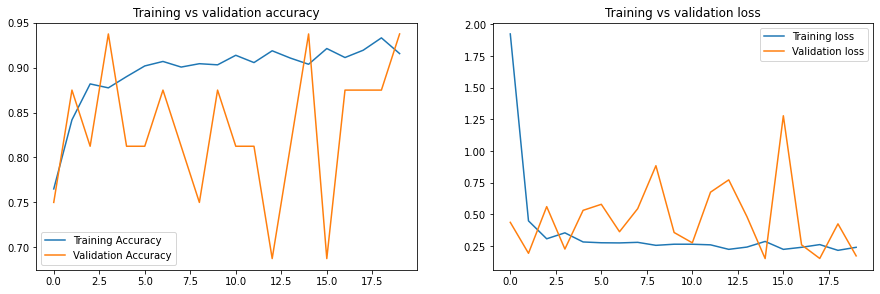

In [29]:
'''training accuracy & validation graphs'''
plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
l = 6
w = 5
fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size = 85)
for i in np.arange(0, l*w):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True ={}'.format(y_pred.argmax(axis=1)[i], y_test.argmax(axis=1)[i]))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=1, hspace = 1)

### Save and Load Model

In [31]:
tf.keras.models.save_model(model,'pneumonia_model.hdf5')

In [34]:
import tensorflow as tf
from keras.preprocessing import image
model = tf.keras.models.load_model('/content/pneumonia_model.hdf5')
from keras.applications.vgg16 import preprocess_input

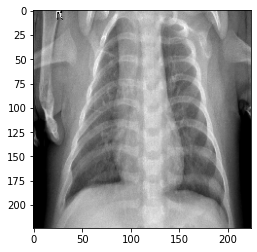

In [52]:
# take a random image and do the prediction
img = image.load_img(r'/content/chest_xray/test/NORMAL/IM-0073-0001.jpeg',target_size=(224, 224))
img_plot = plt.imshow(img)

In [53]:
# convert the image into an array
X = image.img_to_array(img)
X = np.expand_dims(X, axis=0)

In [54]:
# proprocess the image
img_data = preprocess_input(X)

In [55]:
classes  = model.predict(img_data)
new_pred = np.argmax(classes, axis=1)
if new_pred==[1]:
    print("Prediction: Normal")
else:
    print("Prediction: Pneumonia")

Prediction: Pneumonia
